<a href="https://colab.research.google.com/github/mashaan14/YouTube-channel/blob/main/notebooks/2024_03_21_jraph_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Convolutional Network (GCN) in JAX

## YouTube:
I explained this notebook in a [YouTube video](https://youtu.be/O1zGWMEgW7A).

## Acknowledgment:
I borrowed some code from [Introduction to Graph Neural Nets with JAX/jraph](https://colab.research.google.com/github/deepmind/educational/blob/master/colabs/summer_schools/intro_to_graph_nets_tutorial_with_jraph.ipynb#scrollTo=1n1kCuqtkvfm) and [pytorch-geometric tutorials](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html).

## References:
```bibtex
@inproceedings{Fey/Lenssen/2019,
  title={Fast Graph Representation Learning with {PyTorch Geometric}},
  author={Fey, Matthias and Lenssen, Jan E.},
  booktitle={ICLR Workshop on Representation Learning on Graphs and Manifolds},
  year={2019},
}
```

```bibtex
@software{jraph2020github,
  author = {Jonathan Godwin* and Thomas Keck* and Peter Battaglia and Victor Bapst and Thomas Kipf and Yujia Li and Kimberly Stachenfeld and Petar Veli\v{c}kovi\'{c} and Alvaro Sanchez-Gonzalez},
  title = {{J}raph: {A} library for graph neural networks in jax.},
  url = {http://github.com/deepmind/jraph},
  version = {0.0.1.dev},
  year = {2020},
}
```

I tried to code GCN using different deep learning libraries. Here are the libraries I used to code GCN:

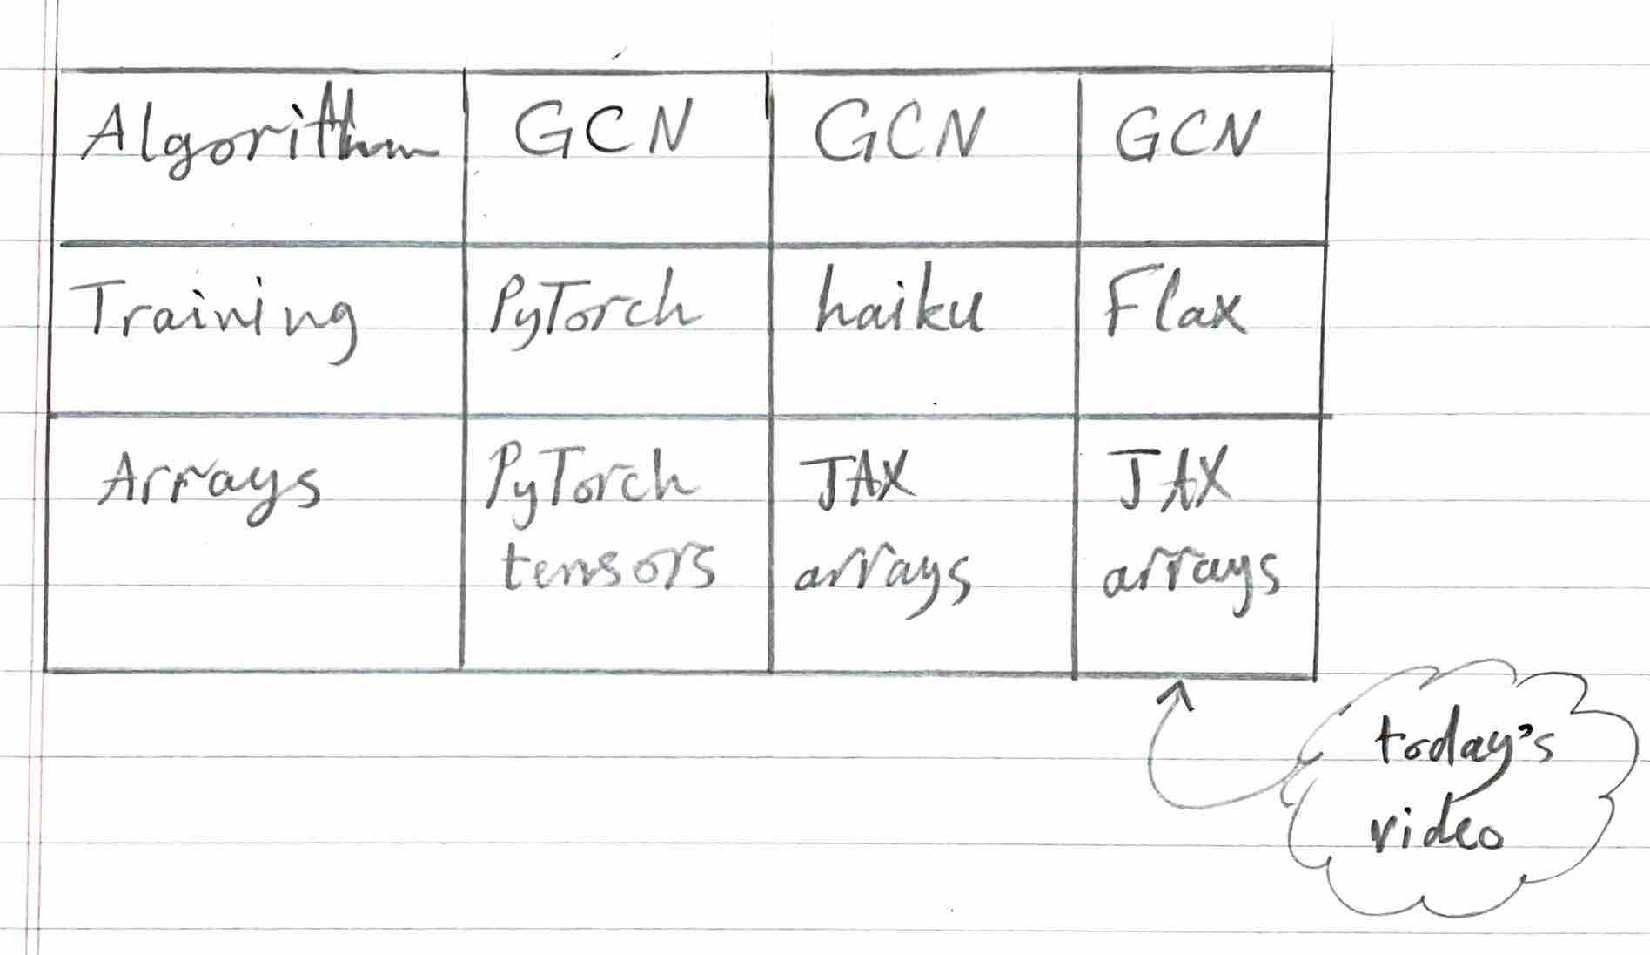

The original GCN algorithm uses two layers as shown in equation (9) by Kipf et al. (2017) in https://arxiv.org/abs/1609.02907

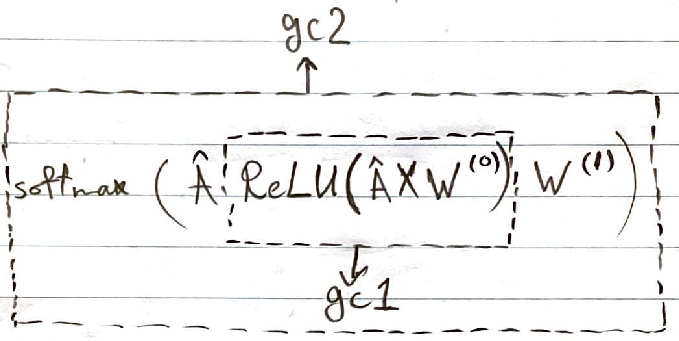

## Import libraries

In [ ]:
# install pytorch_geometric
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# install jraph and jax dependencies
!pip install git+https://github.com/deepmind/jraph.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/deepmind/jraph.git to /tmp/pip-req-build-ul368tox
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/jraph.git /tmp/pip-req-build-ul368tox
  Resolved https://github.com/deepmind/jraph.git to commit 51f5990104f7374492f8f3ea1cbc47feb411c69c
  Preparing metadata (setup.py) ... done


In [ ]:
# Standard libraries
import numpy as np
from scipy import sparse
import seaborn as sns
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
from IPython.display import Javascript  # Restrict height of output cell.

# sklearn
from sklearn.manifold import TSNE

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn import Linear

# PyTorch geometric
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import (Planetoid, KarateClub)
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.data import Data
from torch_geometric import seed_everything

# jax
import jax
import jax.numpy as jnp
import jax.tree_util as tree
import flax
import flax.linen as nn
from flax.training import train_state
import optax
import pickle

# jraph
import jraph
from jraph._src import models as jraph_models

In [ ]:
random_seed = 42
plt.style.use('dark_background')
plot_colors = cm.tab10.colors
accuracy_list = []

## Import Cora Dataset
You can find a description of this dataset in [Pytorch-Geometric documentation](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html#torch_geometric.datasets.Planetoid). In case of `split='full'`, all nodes except those in the validation and test sets will be used for training.

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', split='full', transform=NormalizeFeatures())
num_features = dataset.num_features
num_classes = dataset.num_classes
data_Cora = dataset[0]  # Get the first graph object.
data_Cora

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [ ]:
graph = jraph.GraphsTuple(
      n_node=jnp.asarray([data_Cora.x.shape[0]]),
      n_edge=jnp.asarray([data_Cora.edge_index.shape[1]]),
      # One-hot encoding for nodes, i.e. argmax(nodes) = node index.
      nodes=jnp.eye(data_Cora.x.shape[0]),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([data_Cora.edge_index[0,:]]).squeeze(),
      receivers=jnp.asarray([data_Cora.edge_index[1,:]]).squeeze())

graph_train_mask = jnp.asarray([data_Cora.train_mask]).squeeze()
graph_val_mask = jnp.asarray([data_Cora.val_mask]).squeeze()
graph_test_mask = jnp.asarray([data_Cora.test_mask]).squeeze()
graph_labels = jnp.asarray([data_Cora.y]).squeeze()
one_hot_labels = jax.nn.one_hot(graph_labels, len(jnp.unique(graph_labels)))

Let's check if we have the right number of nodes and edges. We also want to check if we have the correct data types `float32` instead of `torch.float32`

In [ ]:
print(f'Number of nodes: {graph.n_node[0]}')
print(f'Number of edges: {graph.n_edge[0]}')
print(f'Feature matrix data type: {graph.nodes.dtype}')
print(f'senders list data type:   {graph.senders.dtype}')
print(f'receivers list data type: {graph.receivers.dtype}')
print(f'Labels matrix data type:  {graph_labels.dtype}')

Number of nodes: 2708
Number of edges: 10556
Feature matrix data type: float32
senders list data type:   int32
receivers list data type: int32
Labels matrix data type:  int32


## GCN Layers from Jraph

In [ ]:
# Functions must be passed to jraph GNNs, but pytype does not recognise
# linen Modules as callables to here we wrap in a function.
def make_embed_fn(latent_size):
  def embed(inputs):
    return nn.Dense(latent_size)(inputs)
  return embed

def _attention_logit_fn(sender_attr: jnp.ndarray,
                        receiver_attr: jnp.ndarray,
                        edges: jnp.ndarray) -> jnp.ndarray:
  del edges
  x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
  return nn.Dense(1)(x)

In [ ]:
class GCN(nn.Module):
  """Defines a GAT network using FLAX

  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """
  gcn1_output_dim: int
  output_dim: int

  @nn.compact
  def __call__(self, x):
    gcn1 = jraph.GraphConvolution(update_node_fn=lambda n: jax.nn.relu(make_embed_fn(self.gcn1_output_dim)(n)),
                          add_self_edges=True)
    gcn2 = jraph.GraphConvolution(update_node_fn=nn.Dense(self.output_dim))
    return gcn2(gcn1(x))

In [ ]:
model = GCN(8, len(jnp.unique(graph_labels)))
model

GCN(
    # attributes
    gcn1_output_dim = 8
    output_dim = 7
)

## Optimizer and Loss
We set the optimizer to adam using `optax` library. Then we initialized the model using random parameters.

In [ ]:
optimizer = optax.adam(learning_rate=0.01)

rng, inp_rng, init_rng = jax.random.split(jax.random.PRNGKey(random_seed), 3)
params = model.init(jax.random.PRNGKey(random_seed),graph)

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

In [ ]:
def compute_loss(state, params, graph, labels, one_hot_labels, mask):
  """Computes loss."""
  pred_graph = state.apply_fn(params, graph)
  preds = jax.nn.log_softmax(pred_graph.nodes)
  loss = optax.softmax_cross_entropy(preds, one_hot_labels)
  loss_mask = jnp.sum(jnp.where(mask, loss, 0)) / jnp.sum(mask)

  pred_labels = jnp.argmax(preds, axis=1)
  acc = (pred_labels == labels)
  acc_mask = jnp.sum(jnp.where(mask, acc, 0)) / jnp.sum(mask)
  return loss_mask, acc_mask

## Training

In [ ]:
@jax.jit  # Jit the function for efficiency
def train_step(state, graph, graph_labels, one_hot_labels, train_mask):
  # Gradient function
  grad_fn = jax.value_and_grad(compute_loss,  # Function to calculate the loss
                                argnums=1,  # Parameters are second argument of the function
                                has_aux=True  # Function has additional outputs, here accuracy
                              )
  # Determine gradients for current model, parameters and batch
  (loss, acc), grads = grad_fn(state, state.params, graph, graph_labels, one_hot_labels, train_mask)
  # Perform parameter update with gradients and optimizer
  state = state.apply_gradients(grads=grads)
  # Return state and any other value we might want
  return state, loss, acc

In [ ]:
def train_model(state, graph, graph_labels, one_hot_labels, train_mask, val_mask, num_epochs):
  # Training loop
  for epoch in range(num_epochs):
    state, loss, acc = train_step(state, graph, graph_labels, one_hot_labels, train_mask)
    val_loss, val_acc = compute_loss(state, state.params, graph, graph_labels, one_hot_labels, val_mask)
    print(f'step: {epoch:03d}, train loss: {loss:.4f}, train acc: {acc:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}')
  return state, acc, val_acc

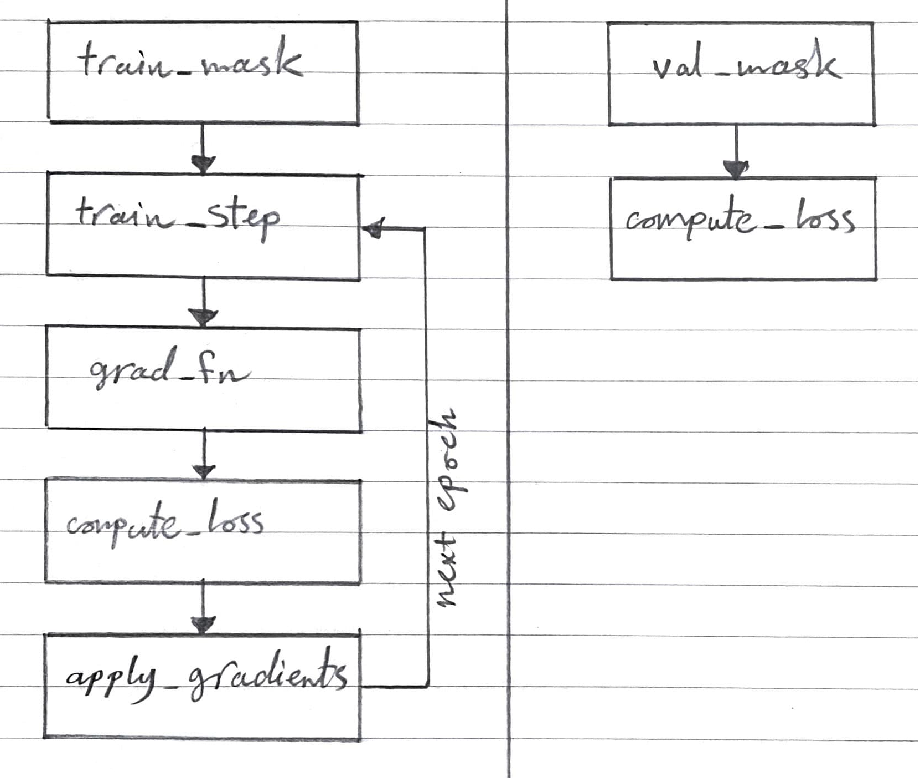

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
trained_model_state, train_acc, val_acc = train_model(model_state, graph, graph_labels, one_hot_labels, graph_train_mask, graph_val_mask, num_epochs=200)
accuracy_list.append(['Cora', 'train', float(train_acc)])
accuracy_list.append(['Cora', 'valid', float(val_acc)])

<IPython.core.display.Javascript object>

step: 000, train loss: 1.9461, train acc: 0.1250, val loss: 1.9348, val acc: 0.2080
step: 001, train loss: 1.9346, train acc: 0.2169, val loss: 1.9232, val acc: 0.2200
step: 002, train loss: 1.9224, train acc: 0.2285, val loss: 1.9098, val acc: 0.2480
step: 003, train loss: 1.9084, train acc: 0.2467, val loss: 1.8948, val acc: 0.3020
step: 004, train loss: 1.8927, train acc: 0.2988, val loss: 1.8787, val acc: 0.3740
step: 005, train loss: 1.8755, train acc: 0.3725, val loss: 1.8613, val acc: 0.4440
step: 006, train loss: 1.8570, train acc: 0.4536, val loss: 1.8429, val acc: 0.5140
step: 007, train loss: 1.8372, train acc: 0.5199, val loss: 1.8233, val acc: 0.5460
step: 008, train loss: 1.8161, train acc: 0.5497, val loss: 1.8025, val acc: 0.5680
step: 009, train loss: 1.7936, train acc: 0.5770, val loss: 1.7807, val acc: 0.5680
step: 010, train loss: 1.7701, train acc: 0.5919, val loss: 1.7584, val acc: 0.5760
step: 011, train loss: 1.7459, train acc: 0.5993, val loss: 1.7356, val acc:

## Testing

In [ ]:
test_loss, test_acc = compute_loss(trained_model_state, trained_model_state.params, graph, graph_labels, one_hot_labels, graph_test_mask)
print(f'test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')
accuracy_list.append(['Cora', 'test', float(test_acc)])

test loss: 0.7034, test acc: 0.8190


## Visualizing nodes before and after training

In [ ]:
nodes_untrained = model_state.apply_fn(model_state.params, graph).nodes
z_nodes_untrained = TSNE(n_components=2).fit_transform(nodes_untrained)

nodes_trained = trained_model_state.apply_fn(trained_model_state.params, graph).nodes
z_nodes_trained = TSNE(n_components=2).fit_transform(nodes_trained)

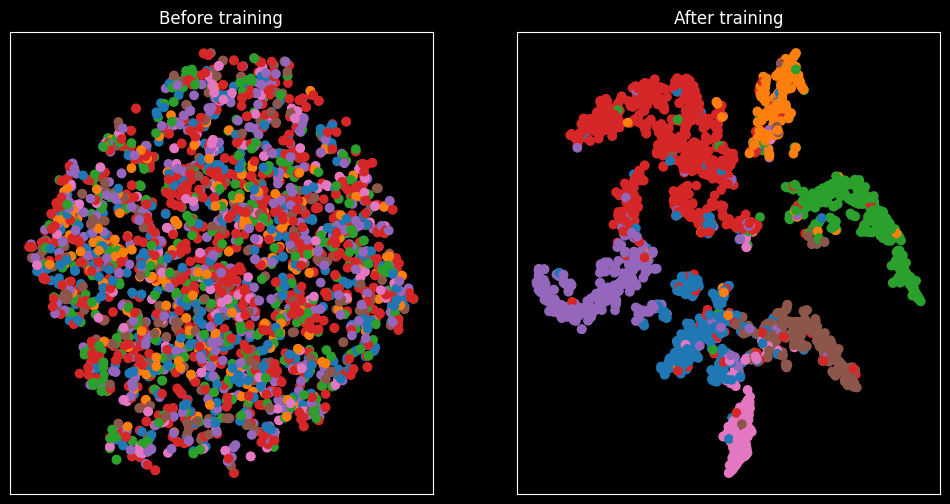

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].set_title('Before training')
axs[0].scatter(z_nodes_untrained[:,0], z_nodes_untrained[:,1], marker='o', color=np.array(plot_colors)[graph_labels])

axs[1].set_title('After training')
axs[1].scatter(z_nodes_trained[:,0], z_nodes_trained[:,1], marker='o', color=np.array(plot_colors)[graph_labels])

for ax in axs:
  ax.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,
            labelbottom=False,labeltop=False,labelleft=False,labelright=False);
  ax.set(xlabel=None, ylabel=None)
plt.show()

## Import CiteSeer Dataset
You can find a description of this dataset in [Pytorch-Geometric documentation](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html#torch_geometric.datasets.Planetoid). In case of `split='full'`, all nodes except those in the validation and test sets will be used for training.

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='CiteSeer', split='full', transform=NormalizeFeatures())
num_features = dataset.num_features
num_classes = dataset.num_classes
data_CiteSeer = dataset[0]  # Get the first graph object.
data_CiteSeer

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

In [ ]:
graph = jraph.GraphsTuple(
      n_node=jnp.asarray([data_CiteSeer.x.shape[0]]),
      n_edge=jnp.asarray([data_CiteSeer.edge_index.shape[1]]),
      # One-hot encoding for nodes, i.e. argmax(nodes) = node index.
      nodes=jnp.eye(data_CiteSeer.x.shape[0]),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([data_CiteSeer.edge_index[0,:]]).squeeze(),
      receivers=jnp.asarray([data_CiteSeer.edge_index[1,:]]).squeeze())

graph_train_mask = jnp.asarray([data_CiteSeer.train_mask]).squeeze()
graph_val_mask = jnp.asarray([data_CiteSeer.val_mask]).squeeze()
graph_test_mask = jnp.asarray([data_CiteSeer.test_mask]).squeeze()
graph_labels = jnp.asarray([data_CiteSeer.y]).squeeze()
one_hot_labels = jax.nn.one_hot(graph_labels, len(jnp.unique(graph_labels)))

In [ ]:
model = GCN(8, len(jnp.unique(graph_labels)))
model

GCN(
    # attributes
    gcn1_output_dim = 8
    output_dim = 6
)

In [ ]:
optimizer = optax.adam(learning_rate=0.01)

rng, inp_rng, init_rng = jax.random.split(jax.random.PRNGKey(random_seed), 3)
params = model.init(jax.random.PRNGKey(random_seed),graph)

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
trained_model_state, train_acc, val_acc = train_model(model_state, graph, graph_labels, one_hot_labels, graph_train_mask, graph_val_mask, num_epochs=200)
accuracy_list.append(['CiteSeer', 'train', float(train_acc)])
accuracy_list.append(['CiteSeer', 'valid', float(val_acc)])

<IPython.core.display.Javascript object>

step: 000, train loss: 1.7911, train acc: 0.2233, val loss: 1.7821, val acc: 0.3740
step: 001, train loss: 1.7814, train acc: 0.4127, val loss: 1.7716, val acc: 0.4880
step: 002, train loss: 1.7694, train acc: 0.5172, val loss: 1.7597, val acc: 0.5340
step: 003, train loss: 1.7557, train acc: 0.5774, val loss: 1.7467, val acc: 0.5580
step: 004, train loss: 1.7403, train acc: 0.6048, val loss: 1.7324, val acc: 0.5740
step: 005, train loss: 1.7232, train acc: 0.6344, val loss: 1.7171, val acc: 0.6000
step: 006, train loss: 1.7046, train acc: 0.6486, val loss: 1.7009, val acc: 0.6060
step: 007, train loss: 1.6846, train acc: 0.6557, val loss: 1.6836, val acc: 0.6140
step: 008, train loss: 1.6633, train acc: 0.6590, val loss: 1.6657, val acc: 0.6120
step: 009, train loss: 1.6410, train acc: 0.6617, val loss: 1.6473, val acc: 0.6120
step: 010, train loss: 1.6179, train acc: 0.6628, val loss: 1.6282, val acc: 0.6160
step: 011, train loss: 1.5939, train acc: 0.6661, val loss: 1.6087, val acc:

In [ ]:
test_loss, test_acc = compute_loss(trained_model_state, trained_model_state.params, graph, graph_labels, one_hot_labels, graph_test_mask)
print(f'test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')
accuracy_list.append(['CiteSeer', 'test', float(test_acc)])

test loss: 1.4912, test acc: 0.6840


## Visualizing nodes before and after training

In [ ]:
nodes_untrained = model_state.apply_fn(model_state.params, graph).nodes
z_nodes_untrained = TSNE(n_components=2).fit_transform(nodes_untrained)

nodes_trained = trained_model_state.apply_fn(trained_model_state.params, graph).nodes
z_nodes_trained = TSNE(n_components=2).fit_transform(nodes_trained)

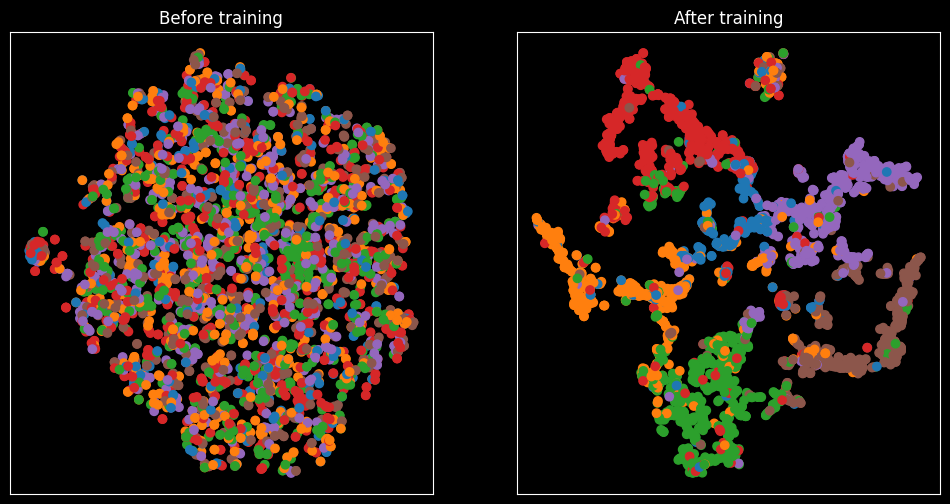

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].set_title('Before training')
axs[0].scatter(z_nodes_untrained[:,0], z_nodes_untrained[:,1], marker='o', color=np.array(plot_colors)[graph_labels])

axs[1].set_title('After training')
axs[1].scatter(z_nodes_trained[:,0], z_nodes_trained[:,1], marker='o', color=np.array(plot_colors)[graph_labels])

for ax in axs:
  ax.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,
            labelbottom=False,labeltop=False,labelleft=False,labelright=False);
  ax.set(xlabel=None, ylabel=None)
plt.show()

## Plotting the results

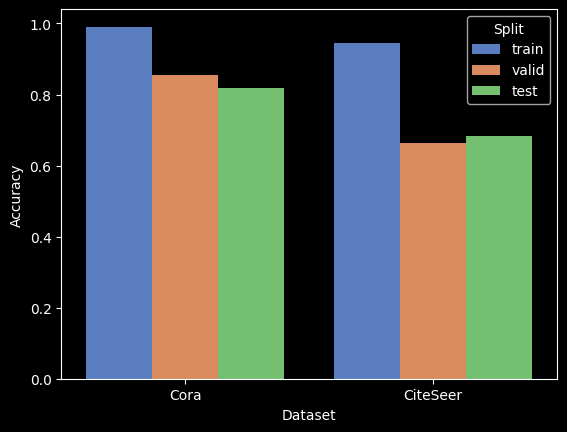

In [ ]:
df = pd.DataFrame(accuracy_list, columns=('Dataset', 'Split', 'Accuracy'))
sns.barplot(df,x='Dataset', y='Accuracy', hue='Split', palette="muted")
plt.show()